In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import fcluster

print("Successful Download")

Successful Download


In [ ]:
df = pd.read_excel('compiled_risk_data.xlsx')
# Converting integers to boolean
df['encode_packed_collision'] = df['encode_packed_collision'].astype(bool)
df['encode_packed_parameters'] = df['encode_packed_parameters'].astype(bool)
df['centralized_risk_low'] = df['centralized_risk_low'].astype(bool)
df['centralized_risk_medium'] = df['centralized_risk_medium'].astype(bool)
df['centralized_risk_high'] = df['centralized_risk_high'].astype(bool)

df.head()

,project_name,Smart contract address,Blog post link,Audit website,Chain,Is_closed_source,hidden_owner,anti_whale_modifiable,Is_anti_whale,Is_honeypot,...,centralized_risk_high,centralized_risk_low,event_setter,external_dependencies,immutable_states,reentrancy_without_eth_transfer,incorrect_inheritance_order,shadowing_local,events_maths,Summary/rationale of risk tags marked true
0,Data Analytics,384571416209d08623c6ace9422613fc8970475d,https://chainsecurity.com/security-audit/circl...,https://chainsecurity.com,Ethereum,False,False,False,False,False,...,False,False,True,True,True,True,False,False,False,Bad Contract: Assigned for flaws that indicate...
1,Data Analytics,0xAb5801a7D398351b8bE11C439e05C5B3259ae9B,https://stackoverflow.com/questions/75030483/w...,https://studygroup.moralis.io/t/compilation-er...,Ethereum,False,False,True,True,False,...,False,True,False,True,False,False,True,False,True,Summary/rationale of risk tags marked true: Th...
2,Data Analytics,0x4B20993Bc481177ec7E8f571ceCaE8A9e22C02db,https://stackoverflow.com/questions/71115106/s...,https://ethereum.stackexchange.com/questions/1...,Ethereum,True,False,False,True,False,...,False,True,False,True,False,False,False,True,True,NaN
3,Data Analytics,0x78731D3Ca6b7E34aC0F824c42a7cC18A495cabaB,https://stackoverflow.com/questions/75030483/w...,https://studygroup.moralis.io/t/compilation-er...,Ethereum,True,False,False,False,True,...,False,True,False,False,True,True,False,False,True,NaN
4,Data Analytics,0x617F2E2fD72FD9D5503197092aC168c91465E7f2,https://stackoverflow.com/questions/69466137/h...,https://ethereum.stackexchange.com/questions/1...,Ethereum,True,False,True,False,True,...,False,False,True,True,False,True,False,False,True,The smart contract is marked with risks such a...


In [ ]:
frequencies = df.select_dtypes(include='bool').apply(lambda x: x.value_counts()).loc[True]
frequencies

,True
Is_closed_source,146
hidden_owner,150
anti_whale_modifiable,112
Is_anti_whale,138
Is_honeypot,89
buy_tax,117
sell_tax,119
slippage_modifiable,139
Is_blacklisted,76
can_take_back_ownership,181


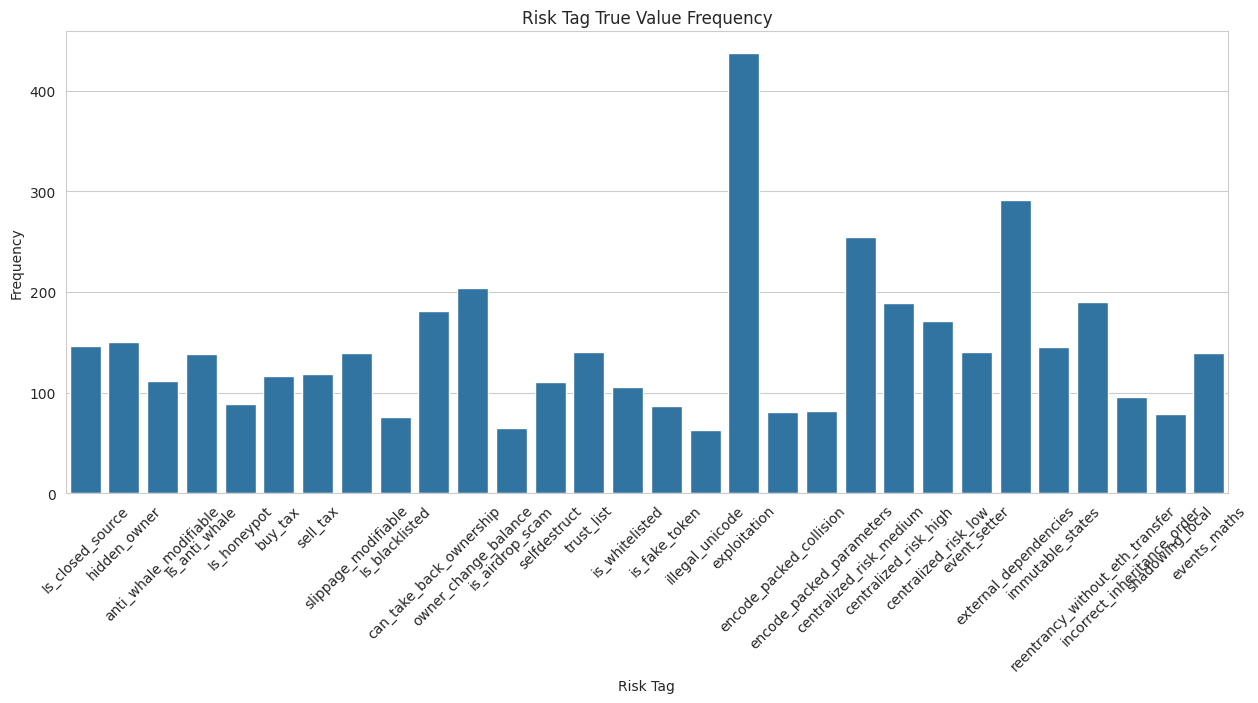

In [ ]:
# Chart Style
sns.set_style("whitegrid")

plt.figure(figsize = (15, 6))
sns.barplot(x = frequencies.index, y = frequencies.values)
plt.title('Risk Tag True Value Frequency')
plt.xlabel('Risk Tag')
plt.ylabel('Frequency')
plt.xticks(rotation = 45)
plt.show()

## Correlation Analysis

In [ ]:
def phi_coefficient(x,y):
  contigency_table = pd.crosstab(x,y)
  chi2 = stats.chi2_contingency(contigency_table, correction = False)[0]
  n = np.sum(np.sum(contigency_table))
  phi = np.sqrt(chi2/n)
  return phi

# Example
phi = phi_coefficient(df['encode_packed_collision'], df['events_maths'])
print(f'Phi Coefficient: {phi}')

Phi Coefficient: 0.4081188023097931


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [ ]:
# For all columns
risk_tags = ['Is_closed_source', 'hidden_owner', 'anti_whale_modifiable', 'Is_anti_whale', 'Is_honeypot',
             'buy_tax', 'sell_tax', 'slippage_modifiable', 'Is_blacklisted', 'can_take_back_ownership',
             'owner_change_balance', 'is_airdrop_scam', 'selfdestruct', 'trust_list', 'is_whitelisted',
             'is_fake_token', 'illegal_unicode', 'exploitation', 'bad_contract', 'reusing_state_variable',
             'encode_packed_collision', 'encode_packed_parameters', 'centralized_risk_medium', 'centralized_risk_high',
             'centralized_risk_low', 'event_setter', 'external_dependencies', 'immutable_states',
             'reentrancy_without_eth_transfer', 'incorrect_inheritance_order', 'shadowing_local', 'events_maths']


risk_df = df[risk_tags]

phi_matrix = pd.DataFrame(index = risk_df.columns, columns = risk_df.columns)

for i in risk_df.columns:
  for j in risk_df.columns:
    phi_matrix.loc[i, j] = phi_coefficient(risk_df[i], risk_df[j])

phi_matrix

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/

,Is_closed_source,hidden_owner,anti_whale_modifiable,Is_anti_whale,Is_honeypot,buy_tax,sell_tax,slippage_modifiable,Is_blacklisted,can_take_back_ownership,...,centralized_risk_medium,centralized_risk_high,centralized_risk_low,event_setter,external_dependencies,immutable_states,reentrancy_without_eth_transfer,incorrect_inheritance_order,shadowing_local,events_maths
Is_closed_source,1.0,0.369825,0.343793,0.315152,0.395294,0.321812,0.387156,0.395293,0.338371,0.271559,...,0.154038,0.214612,0.220922,0.360043,0.132648,0.275936,0.249433,0.342951,0.369848,0.30473
hidden_owner,0.369825,1.0,0.371578,0.356021,0.328014,0.454177,0.422091,0.418828,0.299462,0.372939,...,0.203848,0.329078,0.205706,0.302669,0.129919,0.228094,0.262604,0.335381,0.299793,0.190843
anti_whale_modifiable,0.343793,0.371578,1.0,0.536006,0.443704,0.460264,0.523498,0.625441,0.33861,0.339978,...,0.230758,0.343159,0.179515,0.374556,0.185268,0.300558,0.309001,0.36614,0.411167,0.303052
Is_anti_whale,0.315152,0.356021,0.536006,1.0,0.371245,0.501367,0.513153,0.507013,0.342278,0.281739,...,0.218796,0.290981,0.198353,0.336262,0.170635,0.383476,0.274457,0.34901,0.385632,0.296332
Is_honeypot,0.395294,0.328014,0.443704,0.371245,1.0,0.386469,0.414324,0.389585,0.478634,0.287442,...,0.191032,0.221966,0.274365,0.367158,0.212279,0.387316,0.31973,0.45656,0.440523,0.358995
buy_tax,0.321812,0.454177,0.460264,0.501367,0.386469,1.0,0.710463,0.444537,0.339422,0.326003,...,0.238537,0.288935,0.218673,0.288925,0.157569,0.359325,0.255471,0.354019,0.38716,0.290881
sell_tax,0.387156,0.422091,0.523498,0.513153,0.414324,0.710463,1.0,0.465644,0.381907,0.272188,...,0.290188,0.307546,0.230666,0.328965,0.179746,0.354068,0.337649,0.328301,0.42844,0.295159
slippage_modifiable,0.395293,0.418828,0.625441,0.507013,0.389585,0.444537,0.465644,1.0,0.285621,0.362606,...,0.236443,0.325821,0.242747,0.384301,0.206749,0.315036,0.346361,0.346984,0.415881,0.327842
Is_blacklisted,0.338371,0.299462,0.33861,0.342278,0.478634,0.339422,0.381907,0.285621,1.0,0.244082,...,0.156619,0.330901,0.176874,0.36036,0.185408,0.29712,0.26178,0.378526,0.432002,0.296575
can_take_back_ownership,0.271559,0.372939,0.339978,0.281739,0.287442,0.326003,0.272188,0.362606,0.244082,1.0,...,0.242296,0.358518,0.215368,0.292306,0.136021,0.303422,0.223104,0.354918,0.311808,0.241693


## Heatmap

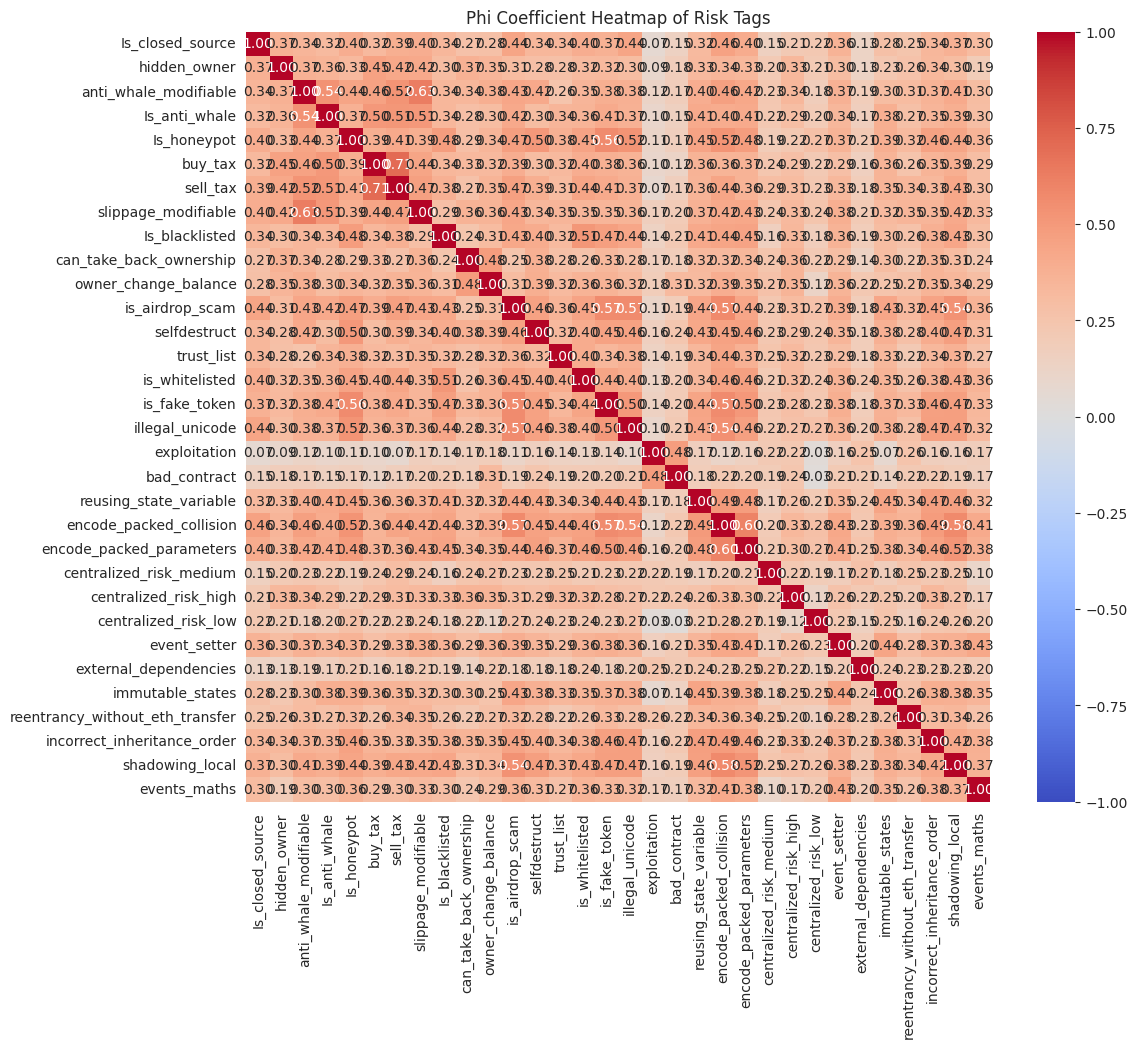

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(phi_matrix.astype(float), annot=True, fmt=".2f", cmap='coolwarm', vmin = -1, vmax = 1)
plt.title('Phi Coefficient Heatmap of Risk Tags')
plt.show()

In [ ]:
df.columns

Index(['project_name', 'Smart contract address', 'Blog post link',
       'Audit website', 'Chain', 'Is_closed_source', 'hidden_owner',
       'anti_whale_modifiable', 'Is_anti_whale', 'Is_honeypot', 'buy_tax',
       'sell_tax', 'slippage_modifiable', 'Is_blacklisted',
       'can_take_back_ownership', 'owner_change_balance', 'is_airdrop_scam',
       'selfdestruct', 'trust_list', 'is_whitelisted', 'is_fake_token',
       'illegal_unicode', 'exploitation', 'bad_contract',
       'reusing_state_variable', 'encode_packed_collision',
       'encode_packed_parameters', 'centralized_risk_medium',
       'centralized_risk_high', 'centralized_risk_low', 'event_setter',
       'external_dependencies', 'immutable_states',
       'reentrancy_without_eth_transfer', 'incorrect_inheritance_order',
       'shadowing_local', 'events_maths',
       'Summary/rationale of risk tags marked true'],
      dtype='object')

In [ ]:
# Features for each risk tag
r1 = 'Is_closed_source'
r2 = 'hidden_owner'
r3 = 'anti_whale_modifiable'
r4 = 'Is_anti_whale'
r5 = 'Is_honeypot'
r6 = 'buy_tax'
r7 = 'sell_tax'
r8 = 'slippage_modifiable'
r9 = 'Is_blacklisted'
r10 = 'can_take_back_ownership'
r11 = 'owner_change_balance'
r12 = 'is_airdrop_scam'
r13 = 'selfdestruct'
r14 = 'trust_list'
r15 = 'is_whitelisted'
r16 = 'is_fake_token'
r17 = 'illegal_unicode'
r18 = 'exploitation'
r19 = 'bad_contract'
r20 = 'reusing_state_variable'
r21 = 'encode_packed_collision'
r22 = 'encode_packed_parameters'
r23 = 'centralized_risk_low'
r24 = 'centralized_risk_medium'
r25 = 'centralized_risk_high'
r26 = 'event_setter'
r27 = 'external_dependencies'
r28 = 'immutable_states'
r29 = 'reentrancy_without_eth_transfer'
r30 = 'incorrect_inheritance_order'
r31 = 'shadowing_local'
r32 = 'events_maths'


## Feature Selection

In [ ]:
feature_selection = df[[r3, r6, r7, r8]].replace({True: 1, False: 0})
print("Based on the heatmap, the feature selection is as followed:")
print(feature_selection.head())

Based on the heatmap, the feature selection is as followed:
   anti_whale_modifiable  buy_tax  sell_tax  slippage_modifiable
0                      0        0         0                    0
1                      1        1         0                    0
2                      0        0         0                    1
3                      0        0         1                    0
4                      1        0         0                    0


## Clustering

### Jaccard Distance

In [ ]:
distance_matrix = pdist(feature_selection, 'jaccard')
distance_square_matrix = squareform(distance_matrix)

In [ ]:
linkage_matrix = sch.linkage(distance_matrix, method='ward')
linkage_matrix

array([[0.00000000e+00, 9.00000000e+00, 0.00000000e+00, 2.00000000e+00],
       [1.00000000e+00, 1.33000000e+02, 0.00000000e+00, 2.00000000e+00],
       [2.00000000e+00, 4.60000000e+01, 0.00000000e+00, 2.00000000e+00],
       ...,
       [1.41200000e+03, 1.92600000e+03, 4.24499618e+00, 7.30000000e+01],
       [1.92900000e+03, 1.93000000e+03, 6.04535273e+00, 2.21000000e+02],
       [1.91700000e+03, 1.93100000e+03, 1.61723906e+01, 9.67000000e+02]])

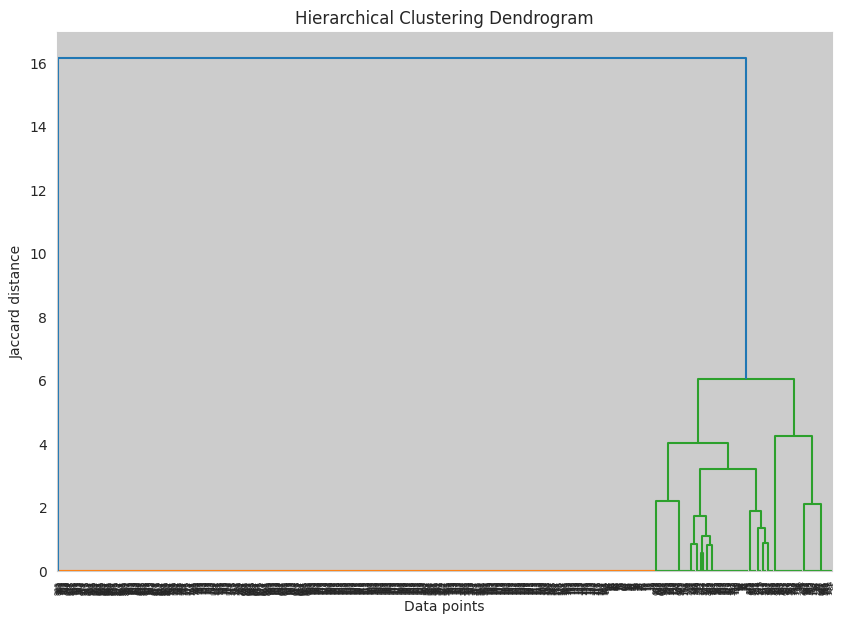

In [ ]:
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data points')
plt.ylabel('Jaccard distance')
plt.show()

In [ ]:
cluster_labels = fcluster(linkage_matrix, t=5, criterion='distance')

df['cluster'] = cluster_labels

cluster_summary = df[[r3, r6, r7, r8,'cluster']].groupby('cluster').agg(['mean', 'std', 'median', 'count'])
cluster_summary

anti_whale_modifiable                          buy_tax            \
                         mean       std median count      mean       std   
cluster                                                                    
1                    0.000000  0.000000    0.0   746  0.000000  0.000000   
2                    0.506757  0.501652    1.0   148  0.790541  0.408305   
3                    0.506849  0.503413    1.0    73  0.000000  0.000000   

                      sell_tax                        slippage_modifiable  \
        median count      mean       std median count                mean   
cluster                                                                     
1          0.0   746  0.000000  0.000000    0.0   746            0.000000   
2          1.0   148  0.804054  0.398275    1.0   148            0.547297   
3          0.0    73  0.000000  0.000000    0.0    73            0.794521   

                                
              std median count  
cluster                         
1        0.000000    0.0   746  
2        0.499448    1.0   148  
3        0.406848    1.0    73

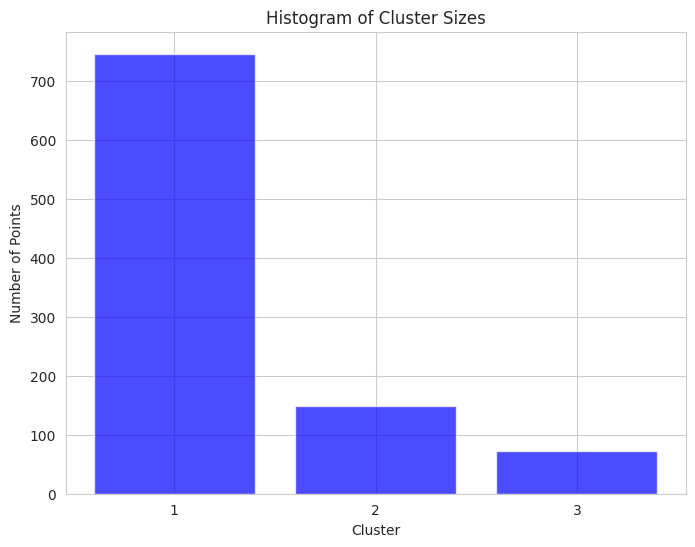

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(cluster_labels, bins=np.arange(1, np.max(cluster_labels)+2)-0.5, rwidth=0.8, color='blue', alpha=0.7)
plt.title('Histogram of Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Number of Points')
plt.xticks(np.arange(1, np.max(cluster_labels)+1))
plt.show()

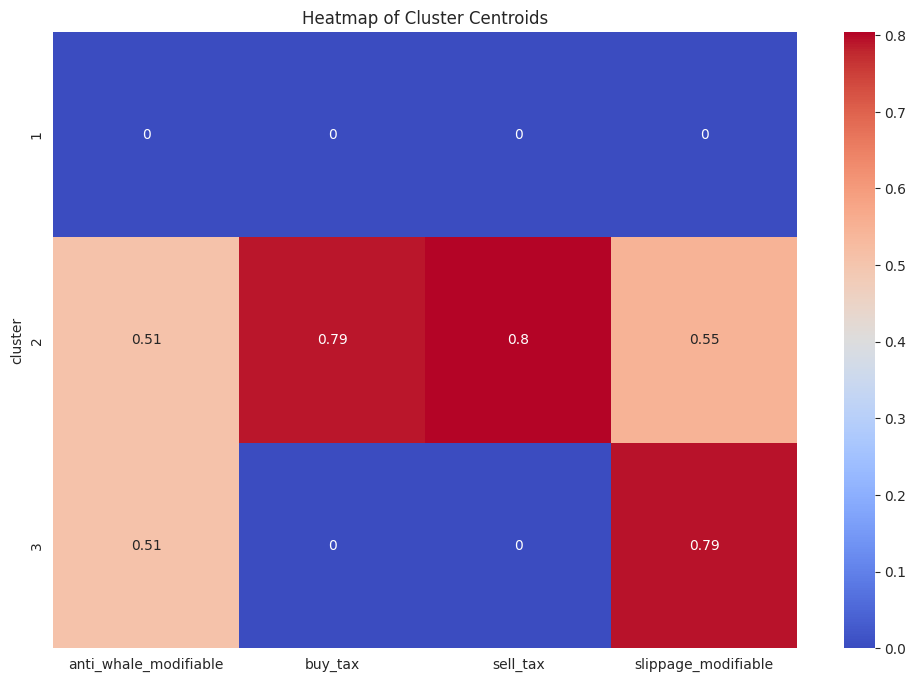

In [ ]:
cluster_centers = df[[r3, r6, r7, r8,'cluster']].groupby('cluster').mean()

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_centers, annot=True, cmap='coolwarm')
plt.title('Heatmap of Cluster Centroids')
plt.show()